## Импортируем все необходимые библиотеки

In [497]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV

## Загрузим датасет [**Ирис**](https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data)

In [498]:
file_path = "data/iris.csv" # https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data

# Получим признаки из датасета
X = np.loadtxt(file_path, delimiter=',', usecols=range(4))
print(X[:5])

# Получим таргеты из датасета
y = np.genfromtxt(file_path, delimiter=',', dtype=str, usecols=4)
print(y[:5])


[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
['Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa']


## Работа с данными

In [499]:
# Выводим размеры X, y в памяти
print(f"Размер матрицы X (признаки): {X.nbytes} байт")
print(f"Размер вектора y (классы): {y.nbytes} байт")

Размер матрицы X (признаки): 4800 байт
Размер вектора y (классы): 9000 байт


In [500]:
# Проверим тип данных
print(f"Тип данных: {y.dtype}")

Тип данных: <U15


In [501]:
# Размер одного элемента
print(f"Размер одного элемента: {y.itemsize} байт")

Размер одного элемента: 60 байт


- U означает, что строки хранятся в формате Unicode.
- 15 указывает на максимальную длину строк, которые могут храниться в массиве. То есть каждая строка может содержать до 15 символов.
- В кодировке UTF-32 каждый символ Unicode занимает 4 байта. Поэтому строка длиной 15 символов будет занимать:
    <br>15 символов * 4 байта на символ = 60 байт

Рассмотрим веса самих данных в матрице и векторе:

- Таблица признаков занимает 150 объектов * 4 колонок * 8 байт (размер float64) = 4800 байт
- Вектор матрицы занимает 150 объектов * 1 колонку * 60 байт (размер U15) = 9000 байт

## Нормализация данных

Чтобы нормализовать данные, нужно для каждого признака (каждой колонки) вычислить минимальное и максимальное значения, а затем масштабировать данные в диапазон от 0 до 1 с использованием формулы:

$$
X_{\text{norm}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
$$

Где:
- $ X $ — это исходные данные.
- $ X_{\text{min}} $ — минимальное значение в колонке.
- $ X_{\text{max}} $ — максимальное значение в колонке.

In [502]:
# Нормализация данных вручную
X_norm = np.zeros_like(X, dtype=float)

for i in range(X.shape[1]):
    X_min = X[:, i].min()
    X_max = X[:, i].max()
    X_norm[:, i] = (X[:, i] - X_min) / (X_max - X_min)

# Выводим первые несколько строк нормализованных данных
print("Нормализованные данные (первые 5 строк):\n", X_norm[:5])

Нормализованные данные (первые 5 строк):
 [[0.22222222 0.625      0.06779661 0.04166667]
 [0.16666667 0.41666667 0.06779661 0.04166667]
 [0.11111111 0.5        0.05084746 0.04166667]
 [0.08333333 0.45833333 0.08474576 0.04166667]
 [0.19444444 0.66666667 0.06779661 0.04166667]]


## Представление одного из признаков в виде категориальной переменной

Представим один из признаков в виде категориальной переменной и разделим его на три типа используя квантили:
    <br>< 0.25 --- small
    <br>0.25 - 0.75 --- medium
    <br>\> 0.75 --- big

In [503]:
# Объединяем X_norm и y
iris_df_norm = np.column_stack((X_norm, y))

iris_df_norm[:5]

array([['0.22222222222222213', '0.6249999999999999',
        '0.06779661016949151', '0.04166666666666667', 'Iris-setosa'],
       ['0.1666666666666668', '0.41666666666666663',
        '0.06779661016949151', '0.04166666666666667', 'Iris-setosa'],
       ['0.11111111111111119', '0.5', '0.05084745762711865',
        '0.04166666666666667', 'Iris-setosa'],
       ['0.08333333333333327', '0.4583333333333333',
        '0.0847457627118644', '0.04166666666666667', 'Iris-setosa'],
       ['0.19444444444444448', '0.6666666666666666',
        '0.06779661016949151', '0.04166666666666667', 'Iris-setosa']],
      dtype='<U32')

In [504]:
# Вычислим квантили: 25% (Q1) и 75% (Q3)
sepal_length = X_norm[:, 0]

Q1 = np.percentile(sepal_length, 0.25)
Q3 = np.percentile(sepal_length, 0.75)

# Функция для категоризации признака
def categorize(value, Q1, Q3):
    if value < Q1:
        return 'small'
    elif value > Q3:
        return 'big'
    else:
        return 'medium'

# Применяем функцию к столбцу 'sepal_length'
categorized_sepal_length = np.array([categorize(value, Q1, Q3) for value in sepal_length])
# Создаем массив с объектным типом
iris_data_cat = X_norm.astype(object)

# Заменяем столбец `sepal_length` на категоризированные значения
iris_data_cat[:, 0] = categorized_sepal_length

# Добавляем целевой вектор
iris_data_cat = np.column_stack((iris_data_cat, y))

iris_data_cat[:10]

array([['big', 0.6249999999999999, 0.06779661016949151,
        0.04166666666666667, 'Iris-setosa'],
       ['big', 0.41666666666666663, 0.06779661016949151,
        0.04166666666666667, 'Iris-setosa'],
       ['big', 0.5, 0.05084745762711865, 0.04166666666666667,
        'Iris-setosa'],
       ['big', 0.4583333333333333, 0.0847457627118644,
        0.04166666666666667, 'Iris-setosa'],
       ['big', 0.6666666666666666, 0.06779661016949151,
        0.04166666666666667, 'Iris-setosa'],
       ['big', 0.7916666666666665, 0.11864406779661016,
        0.12500000000000003, 'Iris-setosa'],
       ['big', 0.5833333333333333, 0.06779661016949151,
        0.08333333333333333, 'Iris-setosa'],
       ['big', 0.5833333333333333, 0.0847457627118644,
        0.04166666666666667, 'Iris-setosa'],
       ['medium', 0.3749999999999999, 0.06779661016949151,
        0.04166666666666667, 'Iris-setosa'],
       ['big', 0.4583333333333333, 0.0847457627118644, 0.0,
        'Iris-setosa']], dtype=object)

## Разделение данных на train и test

Разделим датасет на две случайные выборки (0.8 / 0.2)

In [505]:
# Получаем количество строк в датасете
n = len(iris_df_norm)

indices = np.random.permutation(n)

# Определяем точку разбиения (80% для обучающей выборки)
split_point = int(n * 0.8)


In [506]:

# Разбиение массива
train_df_norm = iris_df_norm[indices[:split_point]]
test_df_norm = iris_df_norm[indices[split_point:]]

print(f"Размер всей исходной выборки: {n}")
print(f"Размер обучающей выборки: {len(train_df_norm)}")
print(f"Размер тестовой выборки: {len(test_df_norm)}")

Размер всей исходной выборки: 150
Размер обучающей выборки: 120
Размер тестовой выборки: 30


In [507]:
print("Обучающая выборка (первые 5 строк):")
train_df_norm[:5]

Обучающая выборка (первые 5 строк):


array([['0.9444444444444444', '0.25', '1.0', '0.9166666666666666',
        'Iris-virginica'],
       ['0.41666666666666663', '0.8333333333333333',
        '0.033898305084745756', '0.04166666666666667', 'Iris-setosa'],
       ['0.25000000000000006', '0.5833333333333333',
        '0.06779661016949151', '0.04166666666666667', 'Iris-setosa'],
       ['0.4999999999999999', '0.41666666666666663',
        '0.6101694915254237', '0.5416666666666666', 'Iris-versicolor'],
       ['0.4722222222222222', '0.2916666666666667', '0.6949152542372881',
        '0.625', 'Iris-versicolor']], dtype='<U32')

In [508]:
print("Тестовая выборка (первые 5 строк):")
test_df_norm[:5]

Тестовая выборка (первые 5 строк):


array([['0.22222222222222213', '0.7499999999999998',
        '0.15254237288135591', '0.12500000000000003', 'Iris-setosa'],
       ['0.9166666666666665', '0.41666666666666663',
        '0.9491525423728813', '0.8333333333333334', 'Iris-virginica'],
       ['0.11111111111111119', '0.5', '0.1016949152542373',
        '0.04166666666666667', 'Iris-setosa'],
       ['0.41666666666666663', '0.2916666666666667',
        '0.6949152542372881', '0.75', 'Iris-virginica'],
       ['0.19444444444444448', '0.6666666666666666',
        '0.06779661016949151', '0.04166666666666667', 'Iris-setosa']],
      dtype='<U32')

## Обучение модели SVC (Support Vector Classifier)

  - Выберем один из [методов классификации](https://scikit-learn.org/stable/supervised_learning.html)
  <br>(к примеру, [SVC](https://scikit-learn.org/stable/modules/svm.html)), <br>обучим на тренировочном датасете, оценим результат на тестовом и сделаем выводы


In [509]:
# Разделяем признаки и целевые значения
X_train = train_df_norm[:, :-1]
y_train = train_df_norm[:, -1]

X_test = test_df_norm[:, :-1]
y_test = test_df_norm[:, -1]

X_train[:5]

array([['0.9444444444444444', '0.25', '1.0', '0.9166666666666666'],
       ['0.41666666666666663', '0.8333333333333333',
        '0.033898305084745756', '0.04166666666666667'],
       ['0.25000000000000006', '0.5833333333333333',
        '0.06779661016949151', '0.04166666666666667'],
       ['0.4999999999999999', '0.41666666666666663',
        '0.6101694915254237', '0.5416666666666666'],
       ['0.4722222222222222', '0.2916666666666667', '0.6949152542372881',
        '0.625']], dtype='<U32')

In [510]:

# Преобразуем данные в числовой тип
X_train = X_train.astype(float)
X_test = X_test.astype(float)

X_train[:5]

array([[0.94444444, 0.25      , 1.        , 0.91666667],
       [0.41666667, 0.83333333, 0.03389831, 0.04166667],
       [0.25      , 0.58333333, 0.06779661, 0.04166667],
       [0.5       , 0.41666667, 0.61016949, 0.54166667],
       [0.47222222, 0.29166667, 0.69491525, 0.625     ]])

In [511]:

# Создаем модель SVC
model = SVC()

# Обучаем модель на тренировочном наборе данных
model.fit(X_train, y_train)

SVC()

## Предсказания модели и их оценка

In [512]:
# Прогнозируем результаты на тестовом наборе данных
y_pred = model.predict(X_test)

# Оцениваем точность модели на тестовом наборе
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Вычисляем Precision
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")

# Вычисляем Recall
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {recall:.4f}")

# Вычисляем F1-Score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9333
Precision: 0.9481
Recall: 0.9333
F1-Score: 0.9349


Результаты модели на тестовом наборе данных показывают, что SVC хорошо справляется с задачей классификации в данном случае, показывая сбалансированную производительность по всем метрикам.

## Экспиремент 1. Попробуем обучить модель без нормализации данных

Датасет Iris — относительно простой для классификации. Даже без нормализации SVM может успешно обучиться, особенно если данные хорошо разделимы в исходном пространстве. Добавим искусственный дисбаланс.

In [513]:
# Создаем копию X_train
X_train_imbalance = X_train.copy()

# Умножаем первый столбец (sepal_length) на 1000
X_train_imbalance[:, 0] *= 1000

In [514]:
X_train_imbalance[:5]

array([[9.44444444e+02, 2.50000000e-01, 1.00000000e+00, 9.16666667e-01],
       [4.16666667e+02, 8.33333333e-01, 3.38983051e-02, 4.16666667e-02],
       [2.50000000e+02, 5.83333333e-01, 6.77966102e-02, 4.16666667e-02],
       [5.00000000e+02, 4.16666667e-01, 6.10169492e-01, 5.41666667e-01],
       [4.72222222e+02, 2.91666667e-01, 6.94915254e-01, 6.25000000e-01]])

In [515]:
# Создаем модель SVC
model_imbalance = SVC()

# Обучаем модель на тренировочном наборе данных
model_imbalance.fit(X_train_imbalance, y_train)

SVC()

In [516]:
# Прогнозируем результаты на тестовом наборе данных
y_pred_imbalance = model_imbalance.predict(X_test)

# Оцениваем точность модели на тестовом наборе
accuracy_without_norm = accuracy_score(y_test, y_pred_imbalance)
print(f"Accuracy: {accuracy_without_norm:.4f}")

# Вычисляем Precision
precision_without_norm = precision_score(y_test, y_pred_imbalance, average='weighted')
print(f"Precision: {precision_without_norm:.4f}")

# Вычисляем Recall
recall_without_norm = recall_score(y_test, y_pred_imbalance, average='weighted')
print(f"Recall: {recall_without_norm:.4f}")

# Вычисляем F1-Score
f1_without_norm = f1_score(y_test, y_pred_imbalance, average='weighted')
print(f"F1-Score: {f1_without_norm:.4f}")

Accuracy: 0.3000
Precision: 0.0900
Recall: 0.3000
F1-Score: 0.1385


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Метрики модели значительно ухудшились из-за ненормализованных данных. Без предварительной нормализации признаков различные масштабные значения могут существенно повлиять на работу модели, особенно для алгоритмов, чувствительных к масштабам, таких как SVC. В случае с ненормализованными данными, признаки с большими значениями могут доминировать в процессе обучения.

## Эксперимент 2: Изменяем параметры SVC

In [517]:
# Базовая модель с линейным ядром
model_base = SVC(kernel='linear')
model_base.fit(X_train, y_train)

# Предсказания
y_pred_base = model_base.predict(X_test)

# Метрики
print("Базовая модель (линейное ядро):")
print(classification_report(y_test, y_pred_base))


Базовая модель (линейное ядро):
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         9
Iris-versicolor       0.64      1.00      0.78         7
 Iris-virginica       1.00      0.71      0.83        14

       accuracy                           0.87        30
      macro avg       0.88      0.90      0.87        30
   weighted avg       0.92      0.87      0.87        30



Получили accuracy с линейным ядром чуть хуже, чем в случае, когда обучали с rbf ядром.

In [518]:
# Модель с rbf-ядром
model_rbf = SVC(kernel='rbf', C=1.0, gamma=0.1)
model_rbf.fit(X_train, y_train)

# Предсказания
y_pred_rbf = model_rbf.predict(X_test)

# Метрики
print("Модель с RBF-ядром, коэффициентом регуляризации C = 1.0, гамма параметром gamma = 0.1:")
print(classification_report(y_test, y_pred_rbf))


Модель с RBF-ядром, коэффициентом регуляризации C = 1.0, гамма параметром gamma = 0.1:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         9
Iris-versicolor       0.58      1.00      0.74         7
 Iris-virginica       1.00      0.64      0.78        14

       accuracy                           0.83        30
      macro avg       0.86      0.88      0.84        30
   weighted avg       0.90      0.83      0.84        30



- При gamma=0.1 модель будет использовать ядро, которое имеет относительно широкое влияние. Это может привести к недообучению, когда модель слишком сильно обобщает данные, не учитывая важные различия между примерами.
- Параметр C контролирует степень наказания за ошибки классификации. Чем выше C, тем сильнее модель будет стремиться минимизировать ошибки на обучающем наборе данных, даже если это приводит к более сложным гиперплоскостям и возможному перебучению. В нашем случае C=1.0 это стандартное значение. При C = 1.0 модель будет стремиться к оптимальному балансу между минимизацией ошибок на обучающем наборе данных и простотой модели (сильно подстраиваться под данные не будет).


In [519]:
# Модель с высокой регуляризацией
model_high_C = SVC(kernel='rbf', C=10.0, gamma=0.1)
model_high_C.fit(X_train, y_train)

# Предсказания
y_pred_high_C = model_high_C.predict(X_test)

# Метрики
print("Модель с высокой регуляризацией (C=10):")
print(classification_report(y_test, y_pred_high_C))


Модель с высокой регуляризацией (C=10):
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         9
Iris-versicolor       0.64      1.00      0.78         7
 Iris-virginica       1.00      0.71      0.83        14

       accuracy                           0.87        30
      macro avg       0.88      0.90      0.87        30
   weighted avg       0.92      0.87      0.87        30



Получили значение accuracy лучше, чем в предыдущем случае, за счет C=10.0. Так получилось, потому что при большом значении C, модель будет строить более сложные разделяющие гиперплоскости. Вполне возможно, что C=10.0 и gamma=0.1 компенсировали друг друга.

In [520]:
# Модель с низкой регуляризацией
model_low_C = SVC(kernel='rbf', C=0.1, gamma=0.1)
model_low_C.fit(X_train, y_train)

# Предсказания
y_pred_low_C = model_low_C.predict(X_test)

# Метрики
print("Модель с низкой регуляризацией (C=0.1):")
print(classification_report(y_test, y_pred_low_C))


Модель с низкой регуляризацией (C=0.1):
                 precision    recall  f1-score   support

    Iris-setosa       0.00      0.00      0.00         9
Iris-versicolor       0.23      1.00      0.38         7
 Iris-virginica       0.00      0.00      0.00        14

       accuracy                           0.23        30
      macro avg       0.08      0.33      0.13        30
   weighted avg       0.05      0.23      0.09        30



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Ну тут беда

In [521]:
# Модель с полиномиальным ядром
model_poly = SVC(kernel='poly')
model_poly.fit(X_train, y_train)

# Предсказания
y_pred_poly = model_poly.predict(X_test)

# Метрики
print("Модель с полиномиальным ядром:")
print(classification_report(y_test, y_pred_poly))

Модель с полиномиальным ядром:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         9
Iris-versicolor       0.78      1.00      0.88         7
 Iris-virginica       1.00      0.86      0.92        14

       accuracy                           0.93        30
      macro avg       0.93      0.95      0.93        30
   weighted avg       0.95      0.93      0.93        30



С полиномиальным ядром получили значение accuracy примерно такое же, как и в случае с rbf ядром. Модель обучилась достаточно хорошо.

На самом деле конкретно в нашем случае сидеть перебирать все параметры это бессмысленно, я думаю стоит использовать хотя бы RandomSearch или GridSearch

In [522]:
# Параметры для поиска, включая разные типы ядер
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

# Настройка GridSearchCV для подбора лучших параметров
grid_search = GridSearchCV(model, param_grid, cv=5)

grid_search.fit(X_train, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")

# Оценка на тестовой выборке
y_pred_grid_search = grid_search.predict(X_test)

# Оцениваем точность модели на тестовом наборе
accuracy = accuracy_score(y_test, y_pred_grid_search)
print(f"Accuracy: {accuracy:.4f}")

# Вычисляем Precision
precision = precision_score(y_test, y_pred_grid_search, average='weighted')
print(f"Precision: {precision:.4f}")

# Вычисляем Recall
recall = recall_score(y_test, y_pred_grid_search, average='weighted')
print(f"Recall: {recall:.4f}")

# Вычисляем F1-Score
f1 = f1_score(y_test, y_pred_grid_search, average='weighted')
print(f"F1-Score: {f1:.4f}")

Лучшие параметры: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.9333
Precision: 0.9481
Recall: 0.9333
F1-Score: 0.9349


## Эксперимент 3: Очень маленькая выборка

In [523]:
# Оставим только 10 примеров для обучения
X_train_small = X_train[:10] 
y_train_small = y_train[:10]

# Обучаем модель SVC с линейным ядром на маленькой выборке
model_small_data = SVC(kernel='linear')
model_small_data.fit(X_train_small, y_train_small)

SVC(kernel='linear')

In [524]:
y_pred_small_data = model_small_data.predict(X_test)

# Оцениваем точность модели на тестовом наборе
accuracy_small_data = accuracy_score(y_test, y_pred_small_data)
print(f"Accuracy: {accuracy_small_data:.4f}")

# Вычисляем Precision
precision_small_data = precision_score(y_test, y_pred_small_data, average='weighted')
print(f"Precision: {precision_small_data:.4f}")

# Вычисляем Recall
recall_small_data = recall_score(y_test, y_pred_small_data, average='weighted')
print(f"Recall: {recall_small_data:.4f}")

# Вычисляем F1-Score
f1_small_data = f1_score(y_test, y_pred_small_data, average='weighted')
print(f"F1-Score: {f1_small_data:.4f}")

Accuracy: 0.7667
Precision: 0.5967
Recall: 0.7667
F1-Score: 0.6685


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Я считаю, что данные - это один из самых важных моментов при обучении модели. Маленькая выборка может привести к плохим результатам модели, потому что она ограничивает способность модели выявлять и обобщать закономерности, повышает вероятность переобучения, и снижает стабильность метрик. Чем больше выборка, тем больше данных для обучения, тем лучше модель может«увидеть разнообразие примеров и правильно обучиться, улучшая общую производительность. Данные должны быть качественными. Другое дело, где искать вычислительные мощности для обучения на таких данных, но в нашем случае 150 примеров в датасете - это очень не много.

## Визуализируем датасет, пользуясь методами уменьшения размерности.

Уменьшение размерности — это процесс преобразования данных с высоким числом признаков в данные с меньшим числом признаков, при сохранении значимой информации. Это важный этап машинного обучения, который помогает улучшить производительность моделей, ускорить обучение, а также уменьшить вероятность переобучения. Если данные имеют множество признаков, многие из которых избыточны, применение методов уменьшения размерности поможет улучшить результаты модели.

Основные методы уменьшения размерности:
---

### **1. Методы выбора признаков**
Цель — оставить только наиболее значимые признаки, исключая нерелевантные или избыточные.

#### **Методы отбора на основе статистики:**
- **Метод "выбора по порогу важности"**: Исключаются признаки с низкой важностью (например, используя значения из решающих деревьев или моделей бустинга).
- **ANOVA, χ²-тесты**: Применяются для выбора признаков, имеющих значительную корреляцию с целевой переменной.
- **L1-регуляризация (LASSO)**: Добавляет штраф к коэффициентам регрессии, "обнуляя" малозначимые признаки.

#### **Жадные методы отбора признаков:**
- **Forward Selection**: Постепенно добавляются признаки, которые максимально улучшают модель.
- **Backward Elimination**: Удаляются признаки, минимально влияющие на модель.
- **Recursive Feature Elimination (RFE)**: Итеративное исключение наименее важных признаков.

---

### **2. Методы преобразования признаков**
Цель — создать новые признаки (обычно меньшей размерности) из исходных данных.

#### **PCA (Principal Component Analysis, метод главных компонент):**
- Преобразует исходные данные в новые ортогональные признаки (главные компоненты), которые объясняют наибольшую долю дисперсии данных.
- Используется для анализа данных и предварительной обработки в задачах классификации и кластеризации.

#### **SVD (Singular Value Decomposition, сингулярное разложение):**
- Общее разложение матриц, часто используемое для работы с разреженными данными (например, в рекомендательных системах).
- Может быть применено для уменьшения размерности в задачах обработки текстов (Latent Semantic Analysis, LSA).

#### **t-SNE (t-Distributed Stochastic Neighbor Embedding):**
- Нелинейный метод, хорошо подходит для визуализации данных в 2D или 3D. t-SNE используется в первую очередь для визуализации данных, а не для преобразования данных в новом пространстве для использования в последующих шагах машинного обучения.
- Фокусируется на сохранении локальной структуры данных, t-SNE преобразует высокомерное пространство в низкоразмерное так, чтобы похожие точки в высоком пространстве оставались рядом, а непохожие точки находились дальше друг от друга. Он не сохраняет глобальную структуру данных, то есть распределение в целом может быть искажено.

#### **UMAP (Uniform Manifold Approximation and Projection):**
- Современная альтернатива t-SNE, обеспечивающая быструю и качественную визуализацию.
- Хорошо сохраняет как локальную, так и глобальную структуру данных.

#### **Autoencoders (автокодировщики):**
- Нейронные сети, которые обучаются сжатию данных в "узкое место" (bottleneck), затем восстанавливая их.
- Используются для нелинейного уменьшения размерности и извлечения скрытых признаков.

---

### **3. Методы отбора на основе корреляции**
Цель — исключить сильно коррелирующие признаки, чтобы минимизировать избыточность данных.
- Вычисляется корреляционная матрица, и один из признаков в каждой паре с высокой корреляцией удаляется.
- Более сложные варианты используют меры взаимной информации или зависимость функций.

---

### **4. Линейные модели с регуляризацией**
- Регуляризация (например, L1-регуляризация) помогает уменьшить размерность, присваивая некоторым признакам нулевые веса.

In [525]:
def plot_pca(X, y, plt, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=[{'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}[label] for label in y], cmap='viridis', alpha=0.7)
    legend = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.add_artist(legend)
    plt.set_title(f'PCA - {title}')

def plot_tsne(X, y, plt, title):
    tsne = TSNE(n_components=2, perplexity=min(30, X.shape[0] - 1), random_state=42)
    X_tsne = tsne.fit_transform(X)

    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=[{'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}[label] for label in y], cmap='viridis', alpha=0.7)
    legend = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.add_artist(legend)
    plt.set_title(f't-SNE - {title}')

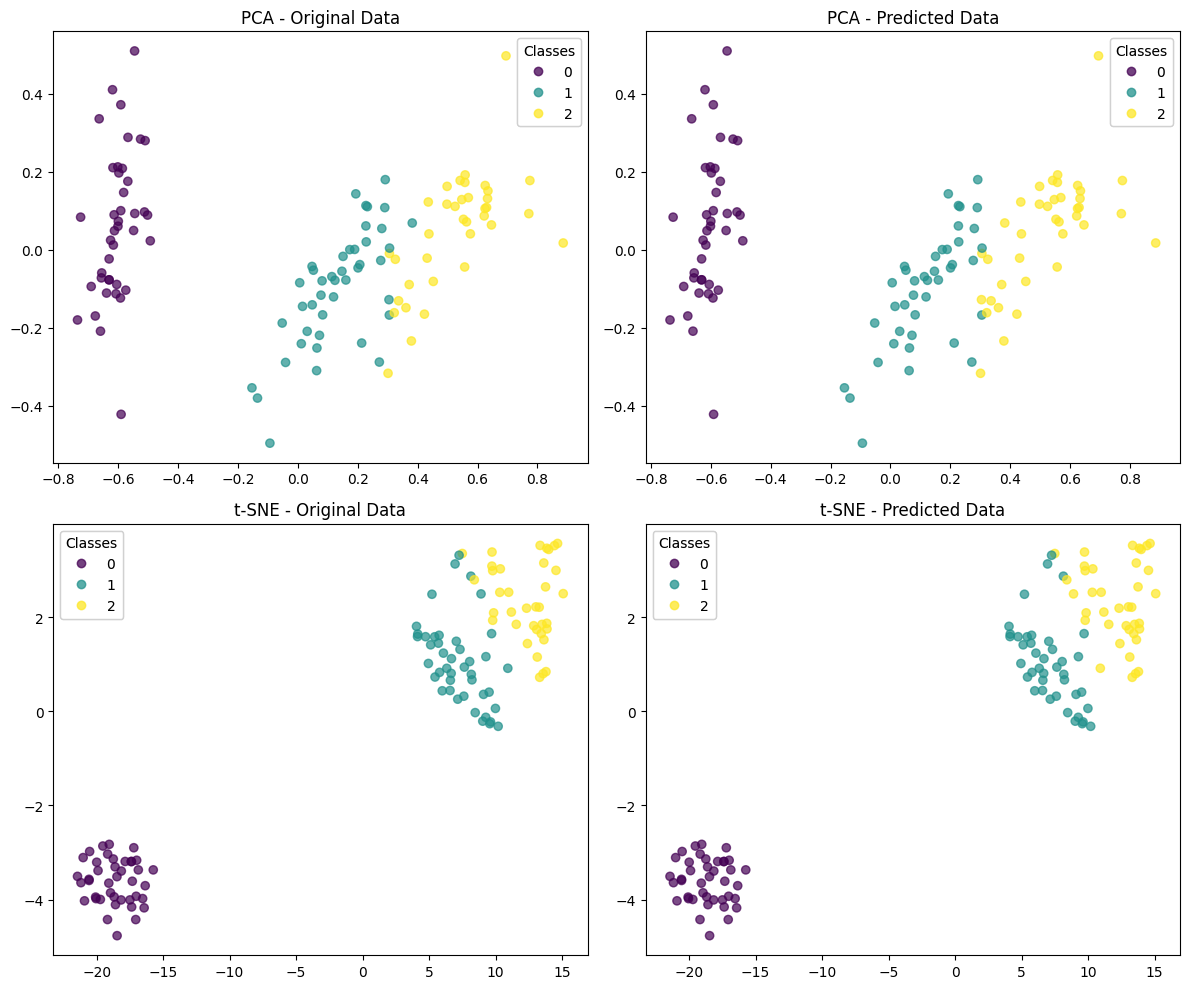

In [526]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Визуализация с использованием PCA и t-SNE для исходных данных
plot_pca(X_train, y_train, axes[0, 0], 'Original Data')
plot_tsne(X_train, y_train, axes[1, 0], 'Original Data')

# Визуализация с использованием PCA и t-SNE для предсказанных данных
plot_pca(X_train, model.predict(X_train), axes[0, 1], 'Predicted Data')
plot_tsne(X_train, model.predict(X_train), axes[1, 1], 'Predicted Data')

plt.tight_layout()
plt.show()